In [1]:
# References :
# https://github.com/SebastianMantey/Decision-Tree-from-Scratch/blob/master/notebooks/Video%2007%20-%20Classification.ipynb
# https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load and prepare data

In [3]:
df = pd.read_csv("./iris.csv")
df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
df.isnull().any()

sepal.length    False
sepal.width     False
petal.length    False
petal.width     False
variety         False
dtype: bool

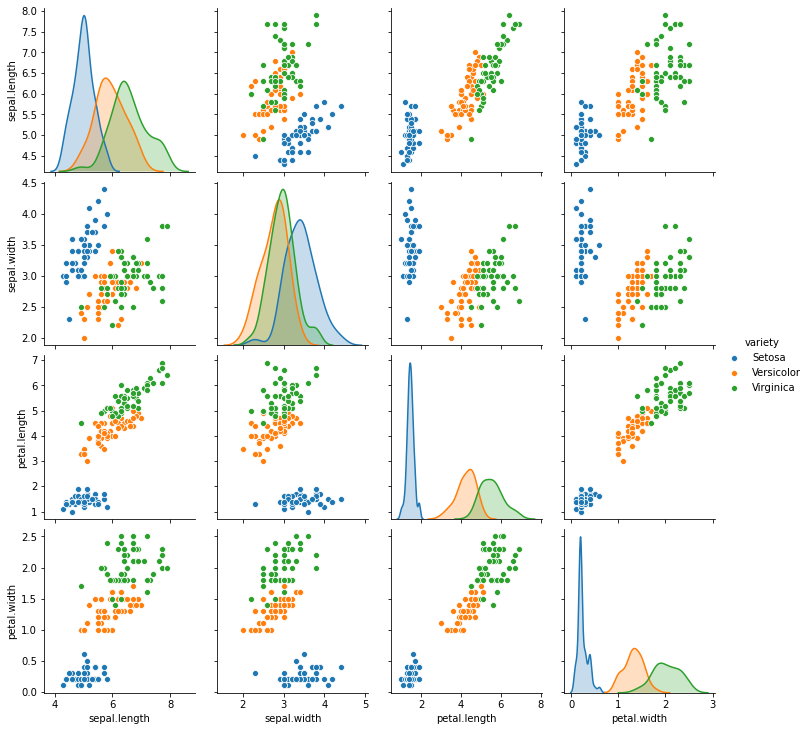

In [6]:
#check the correlation of all the features with each other
sns.pairplot(data=df, hue="variety")

In [7]:
df['variety'] = df['variety'].astype('category').cat.codes

In [8]:
train_df = df.sample(frac=0.8)
test_df = df.loc[~df.index.isin(train_df.index)]
print(train_df.shape)
print(test_df.shape)

(120, 5)
(30, 5)


In [9]:
train_df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
121,5.6,2.8,4.9,2.0,2
79,5.7,2.6,3.5,1.0,1
28,5.2,3.4,1.4,0.2,0
69,5.6,2.5,3.9,1.1,1
43,5.0,3.5,1.6,0.6,0


In [10]:
X_test = test_df.iloc[:,:-1].values
y_test = test_df.iloc[:,-1].values

In [11]:
X_train = train_df.iloc[:,:-1].values
y_train = train_df.iloc[:,-1].values

### Entropy and splitting data

Entropy = −plog2p−qlog2q

Here p and q is probability of success and failure respectively in that node. Entropy is also used with categorical target variable. It chooses the split which has lowest entropy compared to parent node and other splits. The lesser the entropy, the better it is.

Steps to calculate entropy for a split:

* Calculate entropy of parent node
* Calculate entropy of each individual node of split and calculate weighted average of all sub-nodes available in split.

information gain = 1- Entropy

In [12]:
def calculate_entropy(y_label):
    count_classes = np.unique(y_label, return_counts=True)[1]
    proba = count_classes/len(y_label)    
    return sum(-1 * proba * np.log2(proba))

def weighted_entropy(y_left_split, y_right_split):
    
    total = len(y_left_split) + len(y_right_split)    
    frac_left = len(y_left_split) / total
    frac_right = len(y_right_split) / total
    wt_entropy =  (frac_left * calculate_entropy(y_left_split) + frac_right * calculate_entropy(y_right_split))
    return wt_entropy

In [13]:
def get_splits(X_train, y_train):
    best_entropy = 9999

    for feature in range(X_train.shape[1]):
        values = np.unique(X_train[:,feature])
        for val in values:
            left = np.where(X_train[:,feature] <= val)
            right = np.where(X_train[:,feature] > val)
            entropy = weighted_entropy(y_train[left], y_train[right])

            if entropy <= best_entropy :
                best_entropy = entropy
                best_feature = feature
                best_value = val
                best_left = left
                best_right = right
    return best_feature, best_value, best_left, best_right

In [14]:
best_feature, best_value, left, right = get_splits(X_train, y_train)

In [15]:
best_feature, best_value

(3, 0.6)

In [16]:
X_train[left].shape

(37, 4)

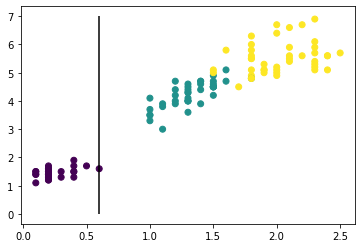

In [17]:
plt.scatter(X_train[:,3], X_train[:,2], c=y_train)
plt.vlines(0.6, 0.0, 7.0)

## Build Tree

In [20]:
def build_tree(X_train, y_train, max_depth=5):
    
    global FEATURES, CLASS_LABEL
    FEATURES = ['sepal.length', 'sepal.width', 'petal.length', 'petal.width']
    CLASS_LABEL = ['Setosa',  'Versicolor', 'Virginica']
    
    if len(np.unique(y_train)) <= 1 or max_depth == 0 or len(y_train) < 2:
        return CLASS_LABEL[y_train[0]]
    
    best_feature, best_value, left, right = get_splits(X_train, y_train)
    tree_splits = "{} <= {}".format(FEATURES[best_feature], best_value)
    tree = {tree_splits : []}
    left_branch = build_tree(X_train[left], y_train[left], max_depth=max_depth-1)
    right_branch = build_tree(X_train[right], y_train[right], max_depth=max_depth-1)
    
    tree[tree_splits].append(left_branch)
    tree[tree_splits].append(right_branch)
    
    return tree

In [21]:
model = build_tree(X_train, y_train, 5)

In [22]:
model

{'petal.width <= 0.6': ['Setosa',
  {'petal.width <= 1.6': [{'petal.length <= 4.9': ['Versicolor',
      {'petal.width <= 1.5': ['Virginica',
        {'petal.length <= 5.1': ['Versicolor', 'Virginica']}]}]},
    {'petal.length <= 4.8': [{'sepal.width <= 3.0': ['Virginica',
        'Versicolor']},
      'Virginica']}]}]}

In [23]:
model.keys()

dict_keys(['petal.width <= 0.6'])

In [24]:
list(model.keys())[0].split()

['petal.width', '<=', '0.6']

In [32]:
model[list(model.keys())[0]]

['Setosa',
 {'petal.width <= 1.6': [{'petal.length <= 4.9': ['Versicolor',
     {'petal.width <= 1.5': ['Virginica',
       {'petal.length <= 5.1': ['Versicolor', 'Virginica']}]}]},
   {'petal.length <= 4.8': [{'sepal.width <= 3.0': ['Virginica',
       'Versicolor']},
     'Virginica']}]}]

In [50]:
test_df.tail()

,sepal.length,sepal.width,petal.length,petal.width,variety
109,7.2,3.6,6.1,2.5,2
124,6.7,3.3,5.7,2.1,2
127,6.1,3.0,4.9,1.8,2
130,7.4,2.8,6.1,1.9,2
134,6.1,2.6,5.6,1.4,2


In [38]:
op={">=": lambda x,y: x>=y, "<=": lambda x,y: x<=y}
node = list(model.keys())[0]
feature_val, _op, split_value = node.split()


In [39]:
node.split()

['petal.width', '<=', '0.6']

In [44]:
op[_op](test_df.iloc[0][feature_val], float(split_value))

True

In [72]:
def predict(model, test):
    
    op={">=": lambda x,y: x>=y, "<=": lambda x,y: x<=y}
    
    node = list(model.keys())[0]
    feature_val, _op, split_value = node.split()
    
    if op[_op](test[feature_val], float(split_value)):
        test_label = model[node][0]
    else:
        test_label = model[node][1]
        
    if not isinstance(test_label, dict):
        return test_label
    
    residual_tree = test_label
    return predict(residual_tree, test)

In [73]:
predict(model, test_df.iloc[0])

'Setosa'

In [74]:
predict(model, test_df.iloc[25])

'Virginica'